In [74]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [75]:
def calculate_angle(p1, p2, p3):
    """Calculate angle between three points."""
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return None
    angle_radians = np.arccos(dot_product / (magnitude_v1 * magnitude_v2))
    return np.degrees(angle_radians)

In [76]:
def calculate_center_point(points):
    """Calculate centroid of multiple points."""
    return np.mean(points, axis=0)

def calculate_velocity(positions, frame_time):
    """Calculate velocity from position differences."""
    return np.gradient(positions, frame_time, axis=0)

def calculate_acceleration(velocities, frame_time):
    """Calculate acceleration from velocities."""
    return np.gradient(velocities, frame_time, axis=0)

In [77]:
# Read input data
input_file = "merged_output.csv"
output_file = "enhanced_motion_features.csv"
frame_time = 0.033  # 30 FPS

df = pd.read_csv(input_file)

In [78]:
df.shape

(7587, 102)

In [79]:
df.describe()

,frame,LEFT_ANKLE_x,LEFT_EAR_x,LEFT_ELBOW_x,LEFT_EYE_x,LEFT_EYE_INNER_x,LEFT_EYE_OUTER_x,LEFT_FOOT_INDEX_x,LEFT_HEEL_x,LEFT_HIP_x,...,RIGHT_EYE_OUTER_z,RIGHT_FOOT_INDEX_z,RIGHT_HEEL_z,RIGHT_HIP_z,RIGHT_INDEX_z,RIGHT_KNEE_z,RIGHT_PINKY_z,RIGHT_SHOULDER_z,RIGHT_THUMB_z,RIGHT_WRIST_z
count,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,...,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000,7587.000000
mean,67.889548,0.544076,0.532059,0.582573,0.524267,0.520057,0.527992,0.554942,0.537680,0.544556,...,-0.277816,0.039162,0.150017,-0.003139,-0.276256,-0.013300,-0.247646,-0.116945,-0.228202,-0.213460
std,74.706272,0.081901,0.077948,0.094496,0.078668,0.078575,0.078913,0.089876,0.081489,0.076709,...,0.166359,0.244971,0.237694,0.056095,0.176601,0.146081,0.174206,0.130982,0.160980,0.160097
min,0.000000,-0.052899,0.162448,0.104798,0.180396,0.182837,0.178310,-0.148446,-0.028424,0.073758,...,-1.114941,-1.656028,-1.378932,-0.257796,-1.112156,-0.759818,-1.037220,-0.691250,-0.954708,-0.909746
25%,25.000000,0.505093,0.499140,0.532811,0.492714,0.488373,0.495985,0.511870,0.498595,0.510799,...,-0.325926,-0.027169,0.077865,-0.012153,-0.337144,-0.055086,-0.314465,-0.161849,-0.287582,-0.276762
50%,50.000000,0.534690,0.521881,0.567316,0.516750,0.512740,0.519910,0.545068,0.528785,0.532364,...,-0.274306,0.061075,0.168524,-0.003880,-0.280720,0.013758,-0.252244,-0.111848,-0.231213,-0.216527
75%,87.000000,0.593588,0.572904,0.642394,0.561359,0.556333,0.568338,0.614262,0.587963,0.589823,...,-0.216265,0.163296,0.271853,0.003954,-0.214789,0.054896,-0.190238,-0.074788,-0.174957,-0.163265
max,519.000000,1.535043,1.052581,1.431981,0.967386,0.949687,0.987501,1.396468,1.609591,1.237211,...,0.707231,1.196070,1.538242,0.257808,1.576373,0.536264,1.631185,0.578070,1.529379,1.541454


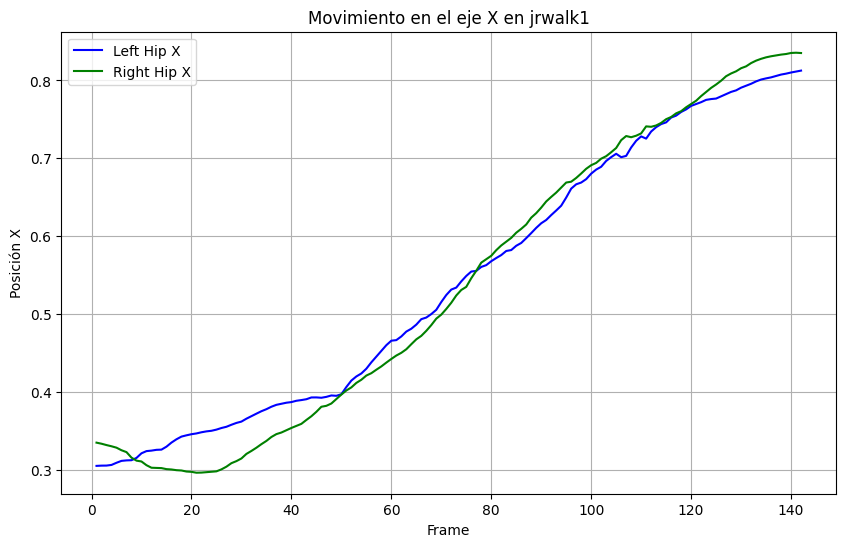

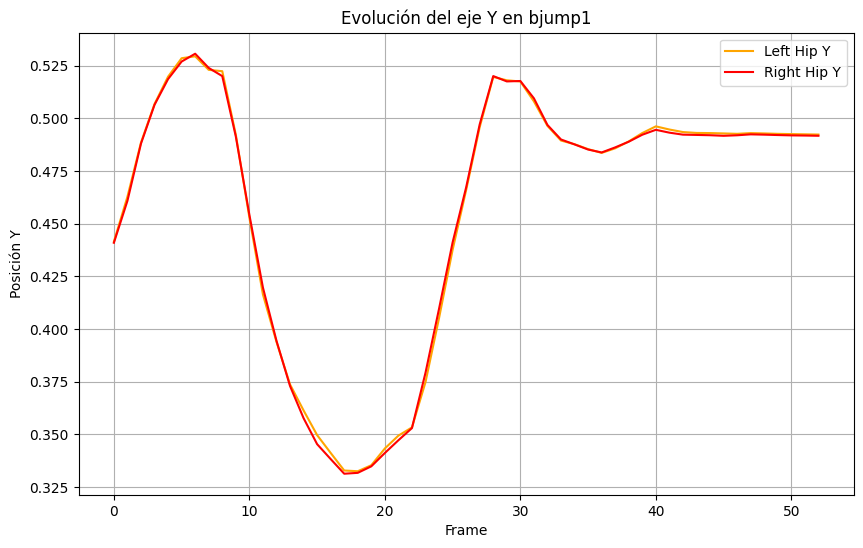

In [80]:
# Filtrar datos por video
video_jrwalk1 = df[df['videoid'] == 'jrwalk1']
video_bjump1 = df[df['videoid'] == 'bjump1']

# Gráfico 1: Movimiento en el eje X (hacia la izquierda) en jrwalk1
plt.figure(figsize=(10, 6))
plt.plot(video_jrwalk1['frame'], video_jrwalk1['LEFT_HIP_x'], label='Left Hip X', color='blue')
plt.plot(video_jrwalk1['frame'], video_jrwalk1['RIGHT_HIP_x'], label='Right Hip X', color='green')
plt.title('Movimiento en el eje X en jrwalk1')
plt.xlabel('Frame')
plt.ylabel('Posición X')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2: Evolución del eje Y en bjump1
plt.figure(figsize=(10, 6))
plt.plot(video_bjump1['frame'], video_bjump1['LEFT_HIP_y'], label='Left Hip Y', color='orange')
plt.plot(video_bjump1['frame'], video_bjump1['RIGHT_HIP_y'], label='Right Hip Y', color='red')
plt.title('Evolución del eje Y en bjump1')
plt.xlabel('Frame')
plt.ylabel('Posición Y')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
from scipy.signal import butter, filtfilt, savgol_filter

# Crear los coeficientes del filtro Butterworth
b, a = butter(N=3, Wn=0.933333, btype='low')

filtered_dataset = df.copy()
smoothed_dataset = df.copy()

video_ids = df["videoid"].unique()

for video_id in video_ids:
    # Filtrar los datos por el ID del video actual
    video_data = df[df["videoid"] == video_id]
    # Identificar columnas numéricas (exceptuando 'frame')
    numeric_columns = video_data.select_dtypes(include=['number']).columns
    columns_to_filter = [col for col in numeric_columns if col != 'frame']
    # Crear copia de los datos originales para aplicar los filtros
    filtered_data = video_data.copy()
    # Aplicar el filtro Butterworth a las columnas seleccionadas
    for column in columns_to_filter:
        filtered_data[column] = filtfilt(b, a, video_data[column])
    # Crear copia para aplicar el filtro Savitzky-Golay
    smoothed_data = filtered_data.copy()
    for column in columns_to_filter:
        smoothed_data[column] = savgol_filter(filtered_data[column], window_length=11, polyorder=3)
    # Reemplazar los datos filtrados y suavizados en los DataFrames finales
    filtered_dataset.loc[video_data.index, columns_to_filter] = filtered_data[columns_to_filter]
    smoothed_dataset.loc[video_data.index, columns_to_filter] = smoothed_data[columns_to_filter]

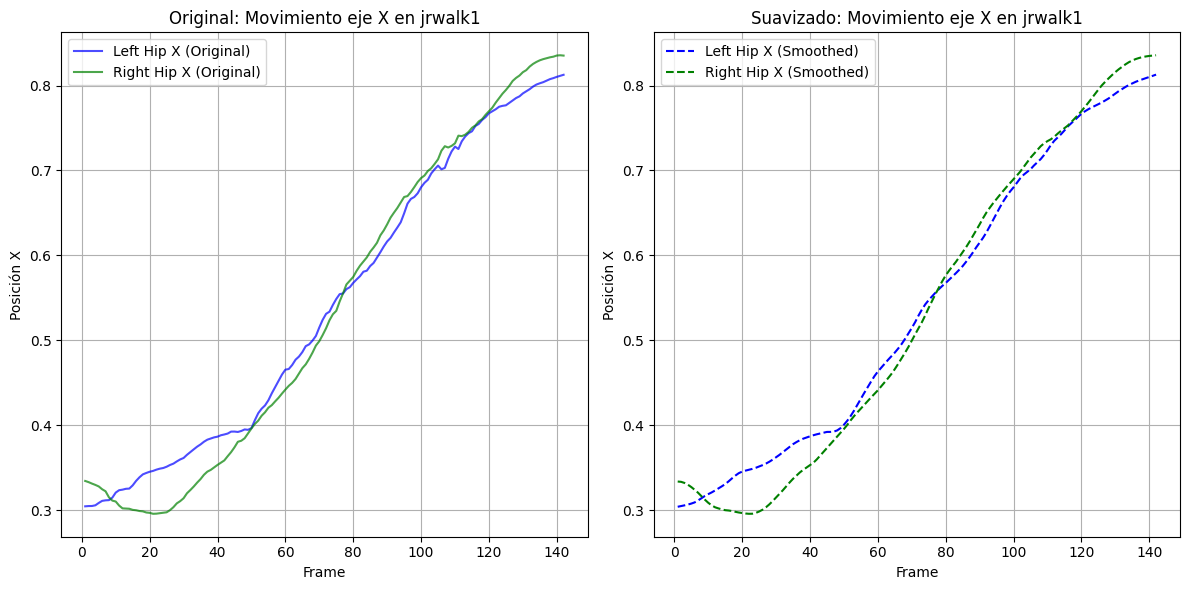

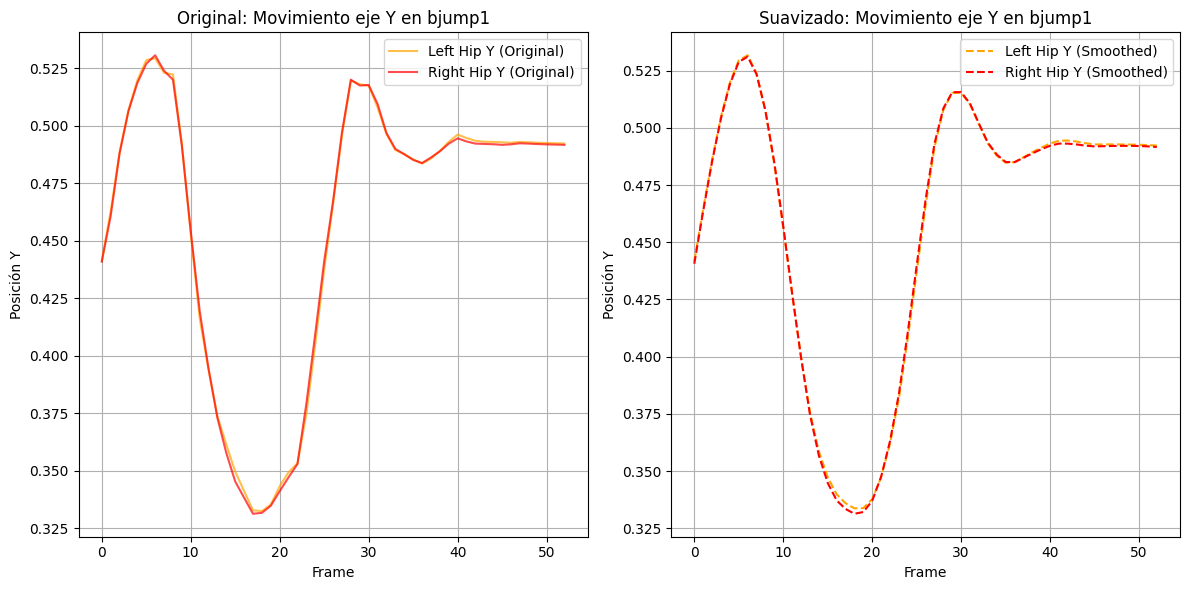

In [82]:
# Gráficas para jrwalk1: Movimiento en el eje X
video_jrwalk1_original = df[df['videoid'] == 'jrwalk1']
video_jrwalk1_smoothed = smoothed_dataset[smoothed_dataset['videoid'] == 'jrwalk1']

plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.plot(video_jrwalk1_original['frame'], video_jrwalk1_original['LEFT_HIP_x'], label='Left Hip X (Original)', color='blue', alpha=0.7)
plt.plot(video_jrwalk1_original['frame'], video_jrwalk1_original['RIGHT_HIP_x'], label='Right Hip X (Original)', color='green', alpha=0.7)
plt.title('Original: Movimiento eje X en jrwalk1')
plt.xlabel('Frame')
plt.ylabel('Posición X')
plt.legend()
plt.grid(True)

# Suavizado
plt.subplot(1, 2, 2)
plt.plot(video_jrwalk1_smoothed['frame'], video_jrwalk1_smoothed['LEFT_HIP_x'], label='Left Hip X (Smoothed)', color='blue', linestyle='--')
plt.plot(video_jrwalk1_smoothed['frame'], video_jrwalk1_smoothed['RIGHT_HIP_x'], label='Right Hip X (Smoothed)', color='green', linestyle='--')
plt.title('Suavizado: Movimiento eje X en jrwalk1')
plt.xlabel('Frame')
plt.ylabel('Posición X')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Gráficas para bjump1: Movimiento en el eje Y
video_bjump1_original = df[df['videoid'] == 'bjump1']
video_bjump1_smoothed = smoothed_dataset[smoothed_dataset['videoid'] == 'bjump1']

plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.plot(video_bjump1_original['frame'], video_bjump1_original['LEFT_HIP_y'], label='Left Hip Y (Original)', color='orange', alpha=0.7)
plt.plot(video_bjump1_original['frame'], video_bjump1_original['RIGHT_HIP_y'], label='Right Hip Y (Original)', color='red', alpha=0.7)
plt.title('Original: Movimiento eje Y en bjump1')
plt.xlabel('Frame')
plt.ylabel('Posición Y')
plt.legend()
plt.grid(True)

# Suavizado
plt.subplot(1, 2, 2)
plt.plot(video_bjump1_smoothed['frame'], video_bjump1_smoothed['LEFT_HIP_y'], label='Left Hip Y (Smoothed)', color='orange', linestyle='--')
plt.plot(video_bjump1_smoothed['frame'], video_bjump1_smoothed['RIGHT_HIP_y'], label='Right Hip Y (Smoothed)', color='red', linestyle='--')
plt.title('Suavizado: Movimiento eje Y en bjump1')
plt.xlabel('Frame')
plt.ylabel('Posición Y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [92]:
filtered_dataset.shape #Shape before dropping duplicates

(7587, 137)

In [93]:
filtered_dataset

,frame,LEFT_ANKLE_x,LEFT_EAR_x,LEFT_ELBOW_x,LEFT_EYE_x,LEFT_EYE_INNER_x,LEFT_EYE_OUTER_x,LEFT_FOOT_INDEX_x,LEFT_HEEL_x,LEFT_HIP_x,...,knee_hip_distance_left,knee_hip_distance_right,hip_ankle_distance_left,hip_ankle_distance_right,vertical_displacement_rolling_mean,vertical_displacement_rolling_std,body_rotation_rolling_mean,body_rotation_rolling_std,step_length_rolling_mean,step_length_rolling_std
0,0,0.584060,0.549612,0.609937,0.540246,0.535110,0.545022,0.605682,0.577711,0.563861,...,0.072118,0.073444,-0.135657,-0.134823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.583828,0.549589,0.609761,0.540183,0.535068,0.544652,0.604022,0.577263,0.563772,...,0.072056,0.073041,-0.135598,-0.134262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.583451,0.549157,0.609153,0.539905,0.534646,0.543977,0.603044,0.576675,0.562721,...,0.072159,0.073049,-0.135685,-0.134263,0.002127,0.003116,-0.177845,0.419580,0.086984,0.001396
3,3,0.583155,0.547484,0.608367,0.539256,0.533723,0.542989,0.602527,0.576497,0.561530,...,0.072283,0.073033,-0.135760,-0.134195,0.001471,0.002145,0.087392,0.322997,0.086251,0.000737
4,4,0.582900,0.545413,0.606326,0.537326,0.531469,0.541362,0.602469,0.576157,0.559688,...,0.072244,0.072898,-0.135619,-0.134091,0.002665,0.003604,0.261075,0.267201,0.085815,0.000461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7582,75,0.540844,0.509889,0.575146,0.500043,0.495894,0.503948,0.561596,0.535356,0.533012,...,0.176354,0.164375,-0.312505,-0.308071,-0.034181,0.070271,-0.808722,2.354682,0.058083,0.000450
7583,76,0.540866,0.509708,0.572927,0.499874,0.495752,0.503928,0.561551,0.535008,0.531668,...,0.175427,0.165587,-0.311455,-0.308006,-0.000882,0.069245,1.043120,3.274997,0.058540,0.000799
7584,77,0.540868,0.508472,0.571048,0.499357,0.495535,0.503563,0.561571,0.534527,0.530356,...,0.172907,0.164026,-0.307717,-0.305991,0.033353,0.059718,2.520701,2.649065,0.059050,0.000970
7585,78,0.540916,0.506946,0.568188,0.498827,0.495304,0.502912,0.561520,0.534507,0.529312,...,0.172570,0.163542,-0.307134,-0.304384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [94]:
filtered_dataset.drop_duplicates().shape #Drop duplicates if any and shaape after dropping duplicates

(7587, 137)

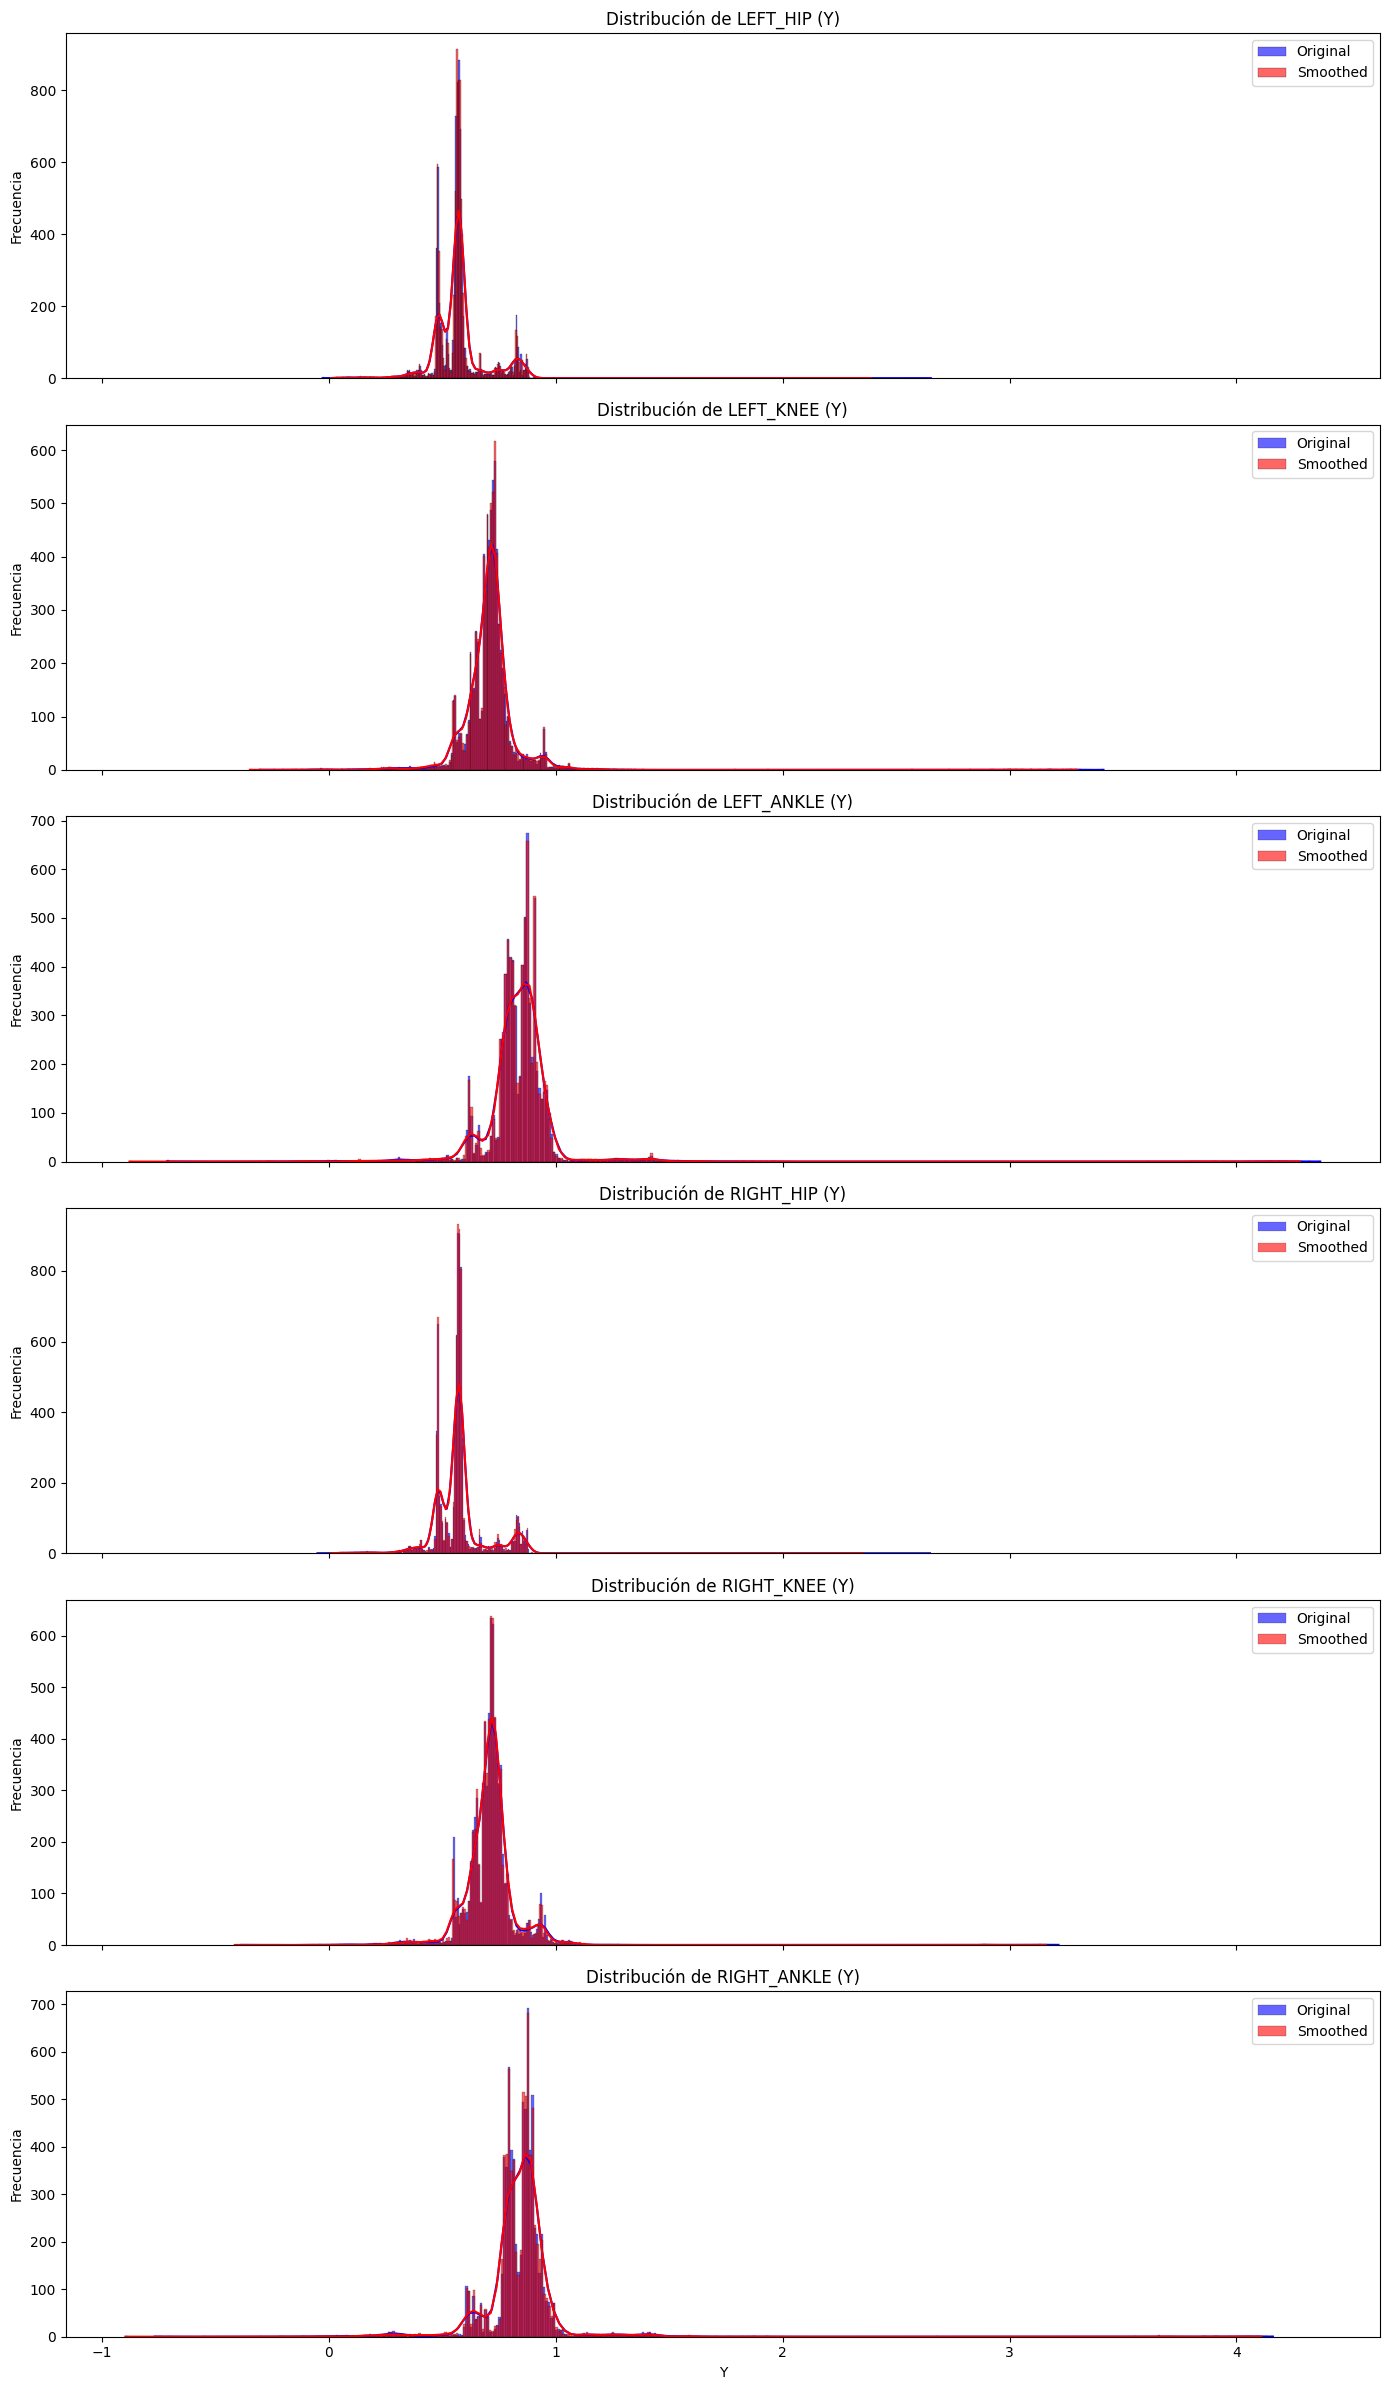

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de keypoints clave
keypoints = [
    "LEFT_HIP", "LEFT_KNEE", "LEFT_ANKLE",
    "RIGHT_HIP", "RIGHT_KNEE", "RIGHT_ANKLE"
]

# Coordenada a graficar
coordinate = 'y'  # Cambia a 'x' si quieres analizar esa coordenada

# Crear una figura con subplots
fig, axes = plt.subplots(len(keypoints), 1, figsize=(14, len(keypoints) * 4), sharex=True)

# Iterar sobre los keypoints y generar gráficos en subplots
for i, keypoint in enumerate(keypoints):
    col_name = f"{keypoint}_{coordinate}"  # Nombre de la columna actual
    
    # Graficar distribución original
    sns.histplot(
        df[col_name], kde=True, 
        color='blue', label='Original', alpha=0.6, ax=axes[i]
    )
    
    # Graficar distribución suavizada
    sns.histplot(
        smoothed_dataset[col_name], kde=True, 
        color='red', label='Smoothed', alpha=0.6, ax=axes[i]
    )
    
    # Configurar título y etiquetas del subplot
    axes[i].set_title(f'Distribución de {keypoint} ({coordinate.upper()})')
    axes[i].set_xlabel(f'{coordinate.upper()}')
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()

# Ajustar diseño para evitar superposición
plt.tight_layout()
plt.show()


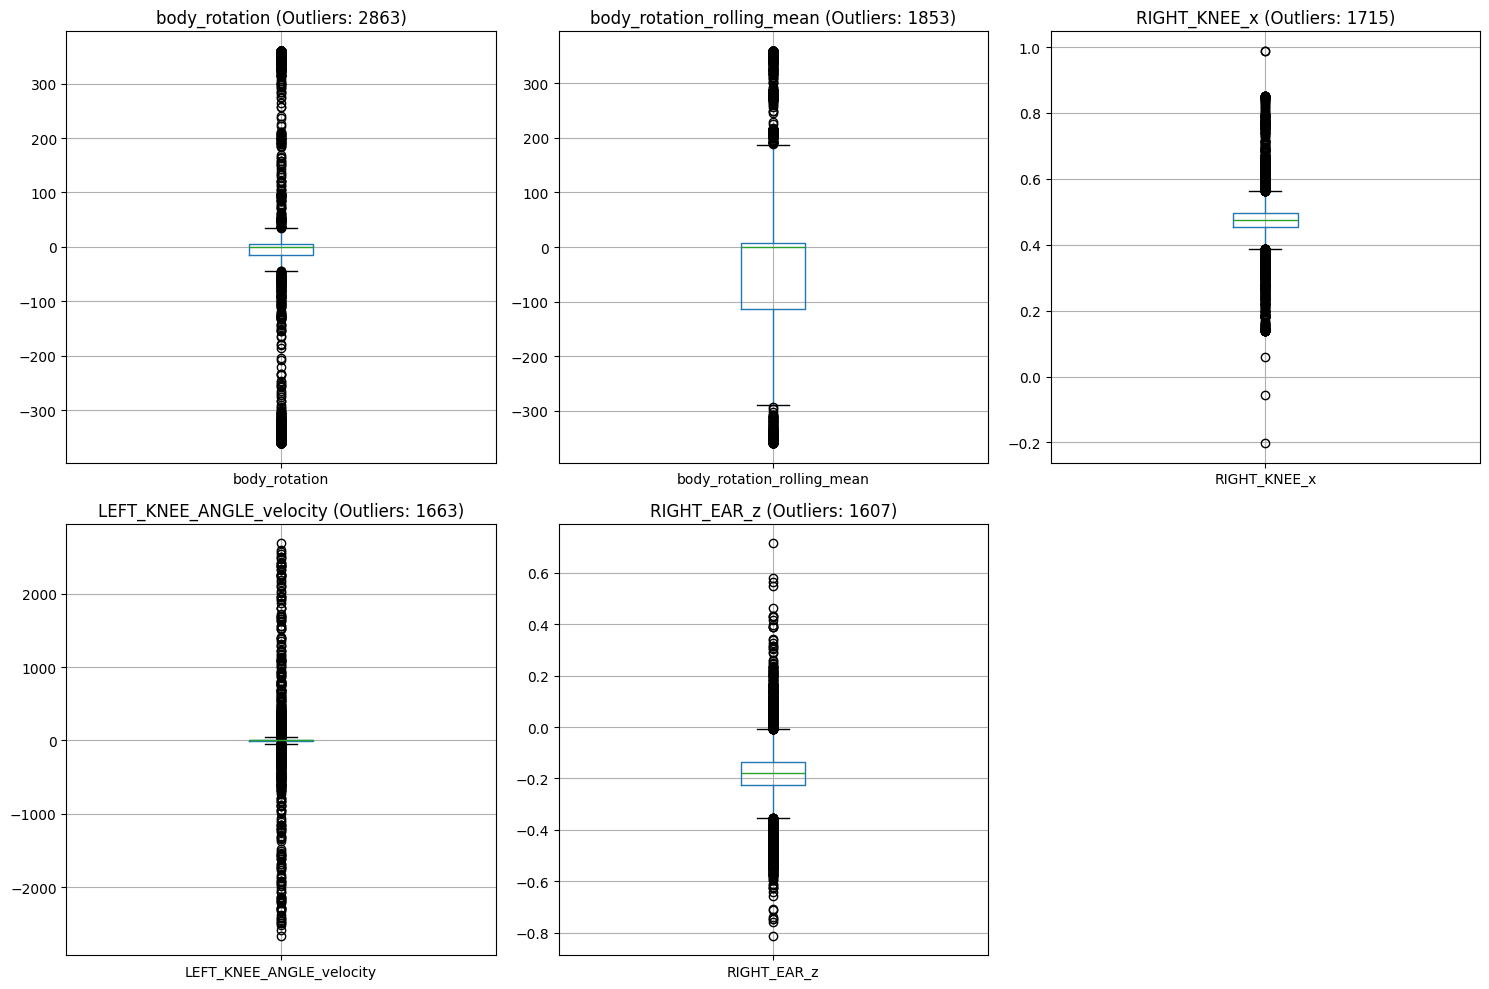

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the IQR for each column
outlier_counts = {}
for column in filtered_dataset.columns:
    if pd.api.types.is_numeric_dtype(filtered_dataset[column]):  # Ensure column is numeric
        Q1 = filtered_dataset[column].quantile(0.25)
        Q3 = filtered_dataset[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Count outliers
        outliers = ((filtered_dataset[column] < lower_bound) | (filtered_dataset[column] > upper_bound)).sum()
        outlier_counts[column] = outliers

# Sort columns by outlier count
sorted_columns = sorted(outlier_counts, key=outlier_counts.get, reverse=True)[:5]

# Plot boxplots for the top 5 columns with the most outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(sorted_columns, start=1):
    plt.subplot(2, 3, i)
    filtered_dataset.boxplot(column=column)
    plt.title(f"{column} (Outliers: {outlier_counts[column]})")
plt.tight_layout()
plt.show()


Aunque se presentan muchos atípicos en este caso no los quitaremos puesto que representan información de los distintos videos, ya que es cuando en la grabación se pasa de estar detenido a en movimiento.

In [86]:
current_dataset = filtered_dataset

keypoints = {
    'LEFT_SHOULDER': ['LEFT_SHOULDER_x', 'LEFT_SHOULDER_y'],
    'RIGHT_SHOULDER': ['RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y'],
    'LEFT_HIP': ['LEFT_HIP_x', 'LEFT_HIP_y'],
    'RIGHT_HIP': ['RIGHT_HIP_x', 'RIGHT_HIP_y'],
    'LEFT_KNEE': ['LEFT_KNEE_x', 'LEFT_KNEE_y'],
    'RIGHT_KNEE': ['RIGHT_KNEE_x', 'RIGHT_KNEE_y'],
    'LEFT_ANKLE': ['LEFT_ANKLE_x', 'LEFT_ANKLE_y'],
    'RIGHT_ANKLE': ['RIGHT_ANKLE_x', 'RIGHT_ANKLE_y'],
    'LEFT_ELBOW': ['LEFT_ELBOW_x', 'LEFT_ELBOW_y'],
    'RIGHT_ELBOW': ['RIGHT_ELBOW_x', 'RIGHT_ELBOW_y'],
    'LEFT_WRIST': ['LEFT_WRIST_x', 'LEFT_WRIST_y'],
    'RIGHT_WRIST': ['RIGHT_WRIST_x', 'RIGHT_WRIST_y']
}

In [87]:
for row_idx, row in current_dataset.iterrows():
    # Knee angles
    current_dataset.loc[row_idx, 'LEFT_KNEE_ANGLE'] = calculate_angle(
        [row[keypoints['LEFT_HIP'][0]], row[keypoints['LEFT_HIP'][1]]],
        [row[keypoints['LEFT_KNEE'][0]], row[keypoints['LEFT_KNEE'][1]]],
        [row[keypoints['LEFT_ANKLE'][0]], row[keypoints['LEFT_ANKLE'][1]]]
    )
    current_dataset.loc[row_idx, 'RIGHT_KNEE_ANGLE'] = calculate_angle(
        [row[keypoints['RIGHT_HIP'][0]], row[keypoints['RIGHT_HIP'][1]]],
        [row[keypoints['RIGHT_KNEE'][0]], row[keypoints['RIGHT_KNEE'][1]]],
        [row[keypoints['RIGHT_ANKLE'][0]], row[keypoints['RIGHT_ANKLE'][1]]]
    )
    
    # Hip angles
    current_dataset.loc[row_idx, 'LEFT_HIP_ANGLE'] = calculate_angle(
        [row[keypoints['LEFT_SHOULDER'][0]], row[keypoints['LEFT_SHOULDER'][1]]],
        [row[keypoints['LEFT_HIP'][0]], row[keypoints['LEFT_HIP'][1]]],
        [row[keypoints['LEFT_KNEE'][0]], row[keypoints['LEFT_KNEE'][1]]]
    )
    current_dataset.loc[row_idx, 'RIGHT_HIP_ANGLE'] = calculate_angle(
        [row[keypoints['RIGHT_SHOULDER'][0]], row[keypoints['RIGHT_SHOULDER'][1]]],
        [row[keypoints['RIGHT_HIP'][0]], row[keypoints['RIGHT_HIP'][1]]],
        [row[keypoints['RIGHT_KNEE'][0]], row[keypoints['RIGHT_KNEE'][1]]]
    )

In [88]:
current_dataset['center_x'] = (current_dataset['LEFT_HIP_x'] + current_dataset['RIGHT_HIP_x']) / 2
current_dataset['center_y'] = (current_dataset['LEFT_HIP_y'] + current_dataset['RIGHT_HIP_y']) / 2

for joint_pair in [
    ('shoulder', ['LEFT_SHOULDER', 'RIGHT_SHOULDER']),
    ('hip', ['LEFT_HIP', 'RIGHT_HIP']),
    ('knee', ['LEFT_KNEE', 'RIGHT_KNEE']),
    ('ankle', ['LEFT_ANKLE', 'RIGHT_ANKLE'])
]:
    name, (left, right) = joint_pair
    current_dataset[f'{name}_distance'] = np.sqrt(
        (current_dataset[keypoints[left][0]] - current_dataset[keypoints[right][0]])**2 +
        (current_dataset[keypoints[left][1]] - current_dataset[keypoints[right][1]])**2
    )

# Calculate velocities and accelerations
print("Calculating velocities and accelerations...")
# Center of mass velocity and acceleration
center_positions = current_dataset[['center_x', 'center_y']].values
center_velocities = calculate_velocity(center_positions, frame_time)
center_accelerations = calculate_acceleration(center_velocities, frame_time)

current_dataset['center_velocity_x'] = center_velocities[:, 0]
current_dataset['center_velocity_y'] = center_velocities[:, 1]
current_dataset['center_acceleration_x'] = center_accelerations[:, 0]
current_dataset['center_acceleration_y'] = center_accelerations[:, 1]

print("Calculating angular velocities...")
for angle in ['LEFT_KNEE_ANGLE', 'RIGHT_KNEE_ANGLE', 'LEFT_HIP_ANGLE', 'RIGHT_HIP_ANGLE']:
    current_dataset[f'{angle}_velocity'] = np.gradient(current_dataset[angle], frame_time)

# Calculate step length (distance between ankles)
current_dataset['step_length'] = np.sqrt(
    (current_dataset['LEFT_ANKLE_x'] - current_dataset['RIGHT_ANKLE_x'])**2 +
    (current_dataset['LEFT_ANKLE_y'] - current_dataset['RIGHT_ANKLE_y'])**2
)

# Calculate body height (shoulder to ankle distance)
current_dataset['body_height_left'] = np.sqrt(
    (current_dataset['LEFT_SHOULDER_x'] - current_dataset['LEFT_ANKLE_x'])**2 +
    (current_dataset['LEFT_SHOULDER_y'] - current_dataset['LEFT_ANKLE_y'])**2
)
current_dataset['body_height_right'] = np.sqrt(
    (current_dataset['RIGHT_SHOULDER_x'] - current_dataset['RIGHT_ANKLE_x'])**2 +
    (current_dataset['RIGHT_SHOULDER_y'] - current_dataset['RIGHT_ANKLE_y'])**2
)

# Calculate movement features
print("Calculating movement features...")
# Vertical displacement (useful for jump detection)
current_dataset['vertical_displacement'] = np.gradient(current_dataset['center_y'], frame_time)
current_dataset['vertical_velocity'] = np.gradient(current_dataset['vertical_displacement'], frame_time)

# Body rotation (angle between shoulders and hips)
current_dataset['body_rotation'] = np.arctan2(
    current_dataset['RIGHT_SHOULDER_y'] - current_dataset['LEFT_SHOULDER_y'],
    current_dataset['RIGHT_SHOULDER_x'] - current_dataset['LEFT_SHOULDER_x']
) - np.arctan2(
    current_dataset['RIGHT_HIP_y'] - current_dataset['LEFT_HIP_y'],
    current_dataset['RIGHT_HIP_x'] - current_dataset['LEFT_HIP_x']
)
current_dataset['body_rotation'] = np.degrees(current_dataset['body_rotation'])

current_dataset['hand_distance_x'] = current_dataset['LEFT_WRIST_x'] - current_dataset['RIGHT_WRIST_x']

# Calculate knee to hip distance
current_dataset['knee_hip_distance_left'] = current_dataset['LEFT_KNEE_y'] - current_dataset['LEFT_HIP_y']

current_dataset['knee_hip_distance_right'] = current_dataset['RIGHT_KNEE_y'] - current_dataset['RIGHT_HIP_y']

current_dataset['hip_ankle_distance_left'] =current_dataset['LEFT_HIP_y'] - current_dataset['LEFT_ANKLE_y']
current_dataset['hip_ankle_distance_right'] = current_dataset['RIGHT_HIP_y'] - current_dataset['RIGHT_ANKLE_y']


# Calculate rolling statistics for temporal context
window_size = 5  # Adjust based on your needs
for col in ['vertical_displacement', 'body_rotation', 'step_length']:
    current_dataset[f'{col}_rolling_mean'] = current_dataset[col].rolling(window=window_size, center=True).mean()
    current_dataset[f'{col}_rolling_std'] = current_dataset[col].rolling(window=window_size, center=True).std()

# Fill NaN values
current_dataset.fillna(0, inplace=True)

# Save enhanced features
print("Saving enhanced features...")
current_dataset.to_csv(output_file, index=False)

Calculating velocities and accelerations...
Calculating angular velocities...
Calculating movement features...
Saving enhanced features...


In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [98]:
feature_columns = [
    'LEFT_KNEE_ANGLE', 'RIGHT_KNEE_ANGLE', 'LEFT_HIP_ANGLE', 'RIGHT_HIP_ANGLE',
    'shoulder_distance', 'hip_distance', 'knee_distance', 'ankle_distance',
    'center_velocity_x', 'center_velocity_y', 'center_acceleration_x', 'center_acceleration_y',
    'LEFT_KNEE_ANGLE_velocity', 'RIGHT_KNEE_ANGLE_velocity',
    'LEFT_HIP_ANGLE_velocity', 'RIGHT_HIP_ANGLE_velocity',
    'step_length', 'body_height_left', 'body_height_right',
    'vertical_displacement', 'vertical_velocity', 'body_rotation',
    'vertical_displacement_rolling_mean', 'vertical_displacement_rolling_std',
    'body_rotation_rolling_mean', 'body_rotation_rolling_std',
    'step_length_rolling_mean', 'step_length_rolling_std', 'hand_distance_x',
    'knee_hip_distance_left', 'knee_hip_distance_right',
    'hip_ankle_distance_left', 'hip_ankle_distance_right'

]

X = current_dataset[feature_columns]
y = current_dataset['annotation']

# Map labels to integers
label_map = {
    'Still': 0, 'approach': 1, 'back': 2, 'jump': 3, 'turn_left': 4,
    'walk_left': 5, 'turn_right': 6, 'walk_right': 7, 'sit': 8, 'stand': 9
}
y = y.map(label_map)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model with optimized parameters
print("Training model...")
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(label_map.keys())))

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Training model...


c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 91.11%

Classification Report:
              precision    recall  f1-score   support

       Still       0.86      0.92      0.89       558
    approach       0.97      0.94      0.95       213
        back       0.99      0.97      0.98       272
        jump       0.92      0.84      0.88        57
   turn_left       0.91      1.00      0.96        43
   walk_left       1.00      0.92      0.96        65
  turn_right       0.96      0.93      0.95        56
  walk_right       0.96      0.98      0.97        93
         sit       0.91      0.90      0.91       112
       stand       0.47      0.29      0.35        49

    accuracy                           0.91      1518
   macro avg       0.89      0.87      0.88      1518
weighted avg       0.91      0.91      0.91      1518



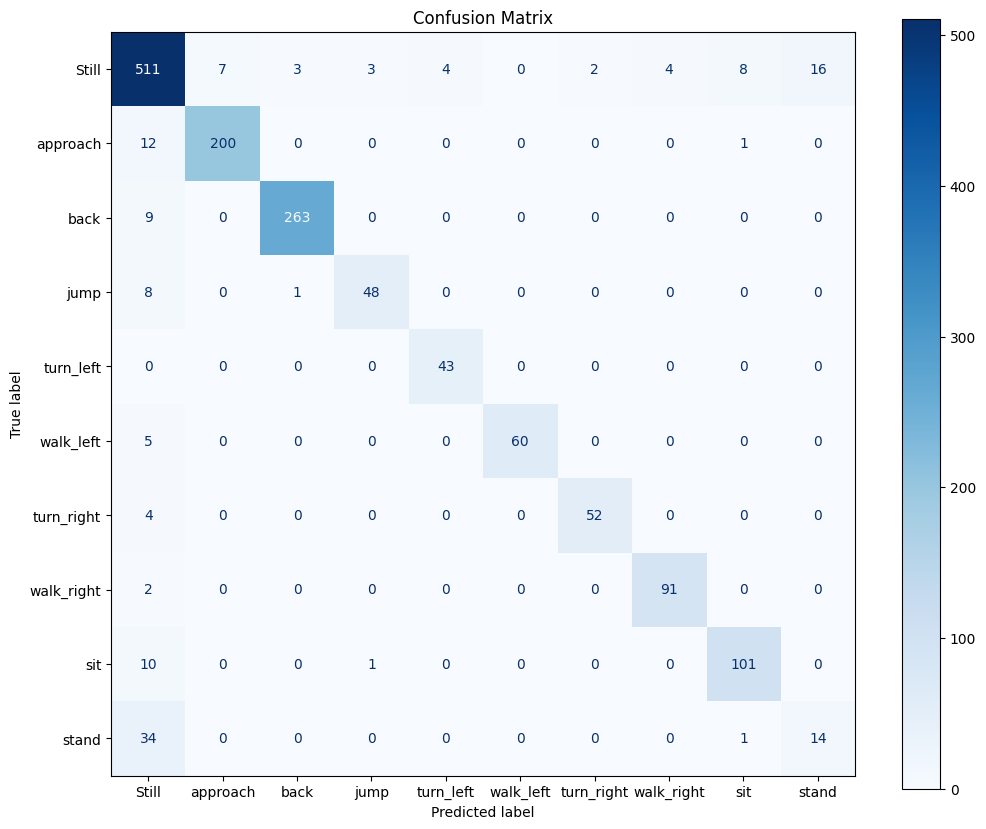

C:\Users\juans\AppData\Local\Temp\ipykernel_44224\3217700525.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=sorted_features, palette="viridis")


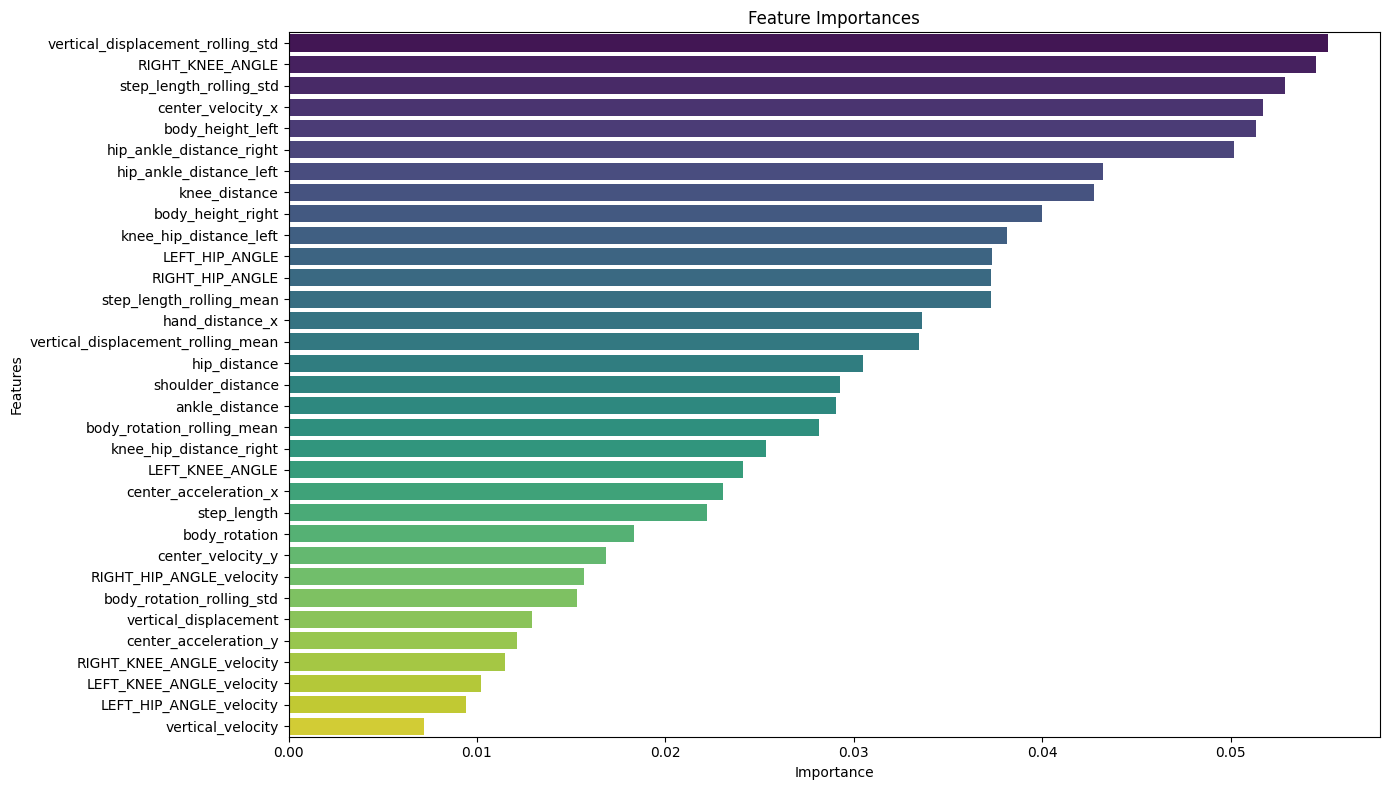

In [99]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_map.keys()))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

# Plot feature importance
feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [feature_columns[i] for i in sorted_idx]

plt.figure(figsize=(14, 8))
sns.barplot(x=feature_importances[sorted_idx], y=sorted_features, palette="viridis")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

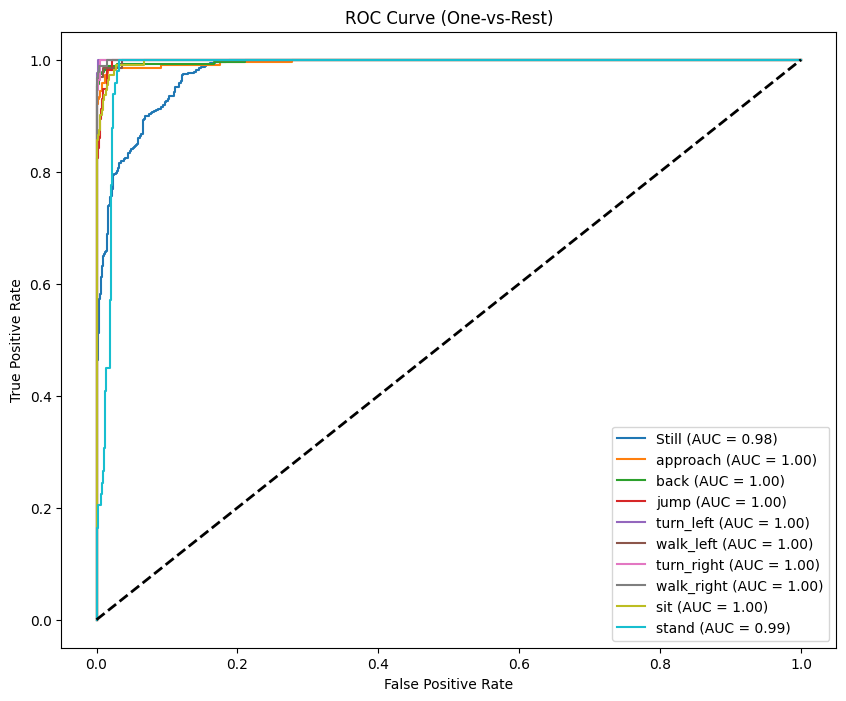

In [101]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=list(label_map.values()))
y_pred_proba = model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_map.keys()):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()


In [103]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import numpy as np

# Definir el modelo base
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Definir los parámetros para el Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Ejecutar el Grid Search
print("Running Grid Search...")
grid_search.fit(X_train, y_train)

# Resultados
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_:.2f}")

# Guardar el mejor modelo
best_model = grid_search.best_estimator_
with open('xgboost_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Evaluar en el conjunto de prueba
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(label_map.keys())))


Running Grid Search...
Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
7 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-package

Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300, 'subsample': 1.0}
Best Score: 0.90
Test Set Accuracy: 91.96%

Classification Report:
              precision    recall  f1-score   support

       Still       0.87      0.92      0.90       558
    approach       0.97      0.95      0.96       213
        back       0.98      0.97      0.98       272
        jump       0.91      0.86      0.88        57
   turn_left       0.93      1.00      0.97        43
   walk_left       1.00      0.97      0.98        65
  turn_right       0.96      0.93      0.95        56
  walk_right       0.98      0.99      0.98        93
         sit       0.92      0.90      0.91       112
       stand       0.53      0.35      0.42        49

    accuracy                           0.92      1518
   macro avg       0.91      0.88      0.89      1518
weighted avg       0.92      0.92      0.92      1518



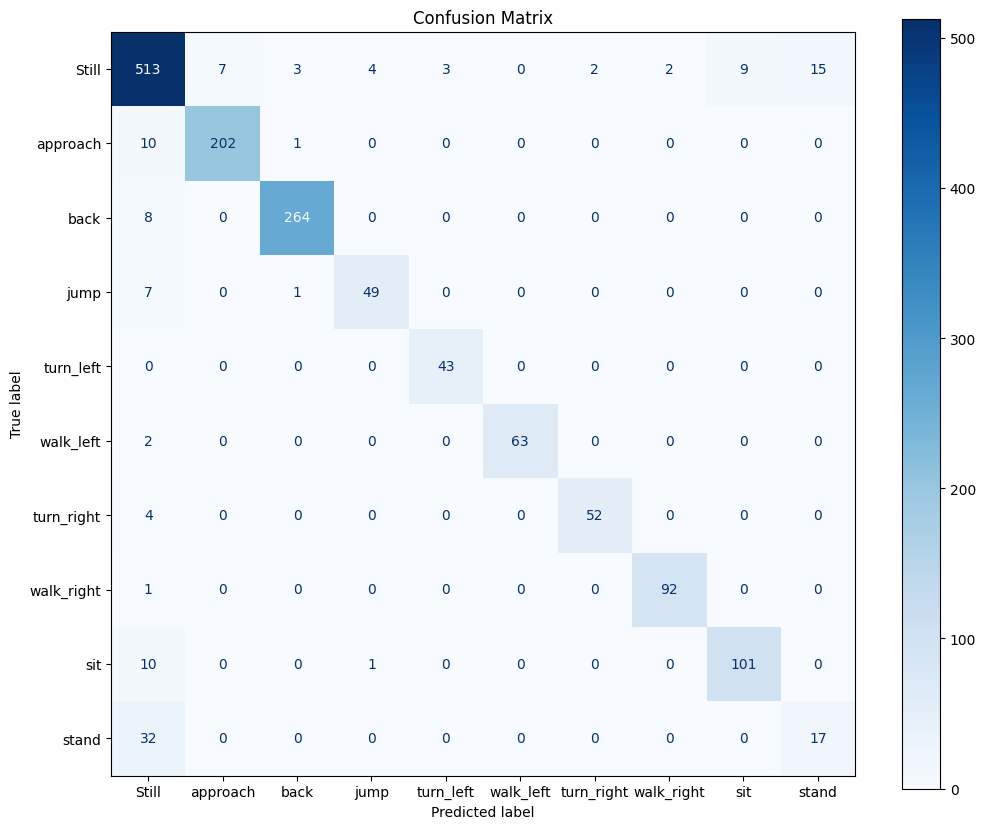

C:\Users\juans\AppData\Local\Temp\ipykernel_44224\1996318044.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=sorted_features, palette="viridis")


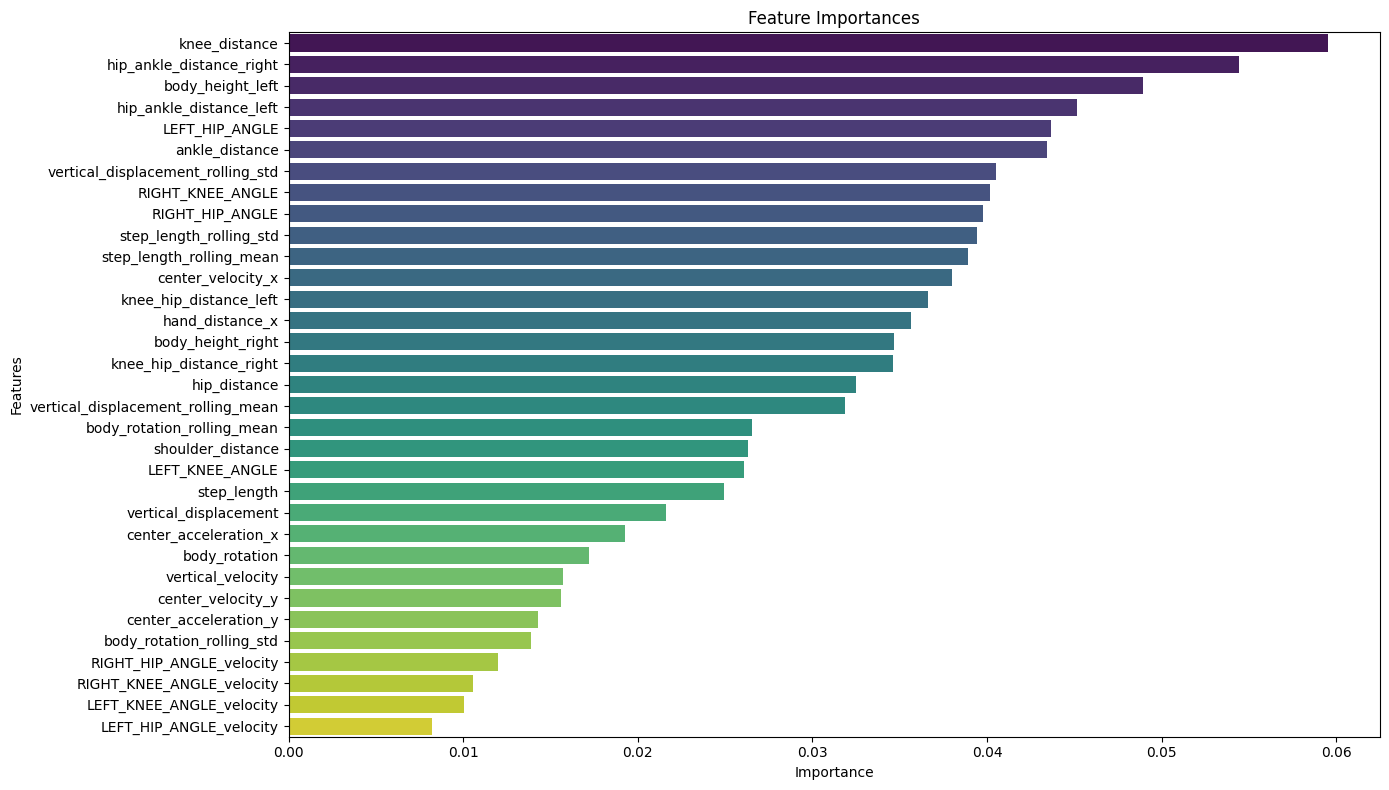

In [104]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_map.keys()))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

# Plot feature importance
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [feature_columns[i] for i in sorted_idx]

plt.figure(figsize=(14, 8))
sns.barplot(x=feature_importances[sorted_idx], y=sorted_features, palette="viridis")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

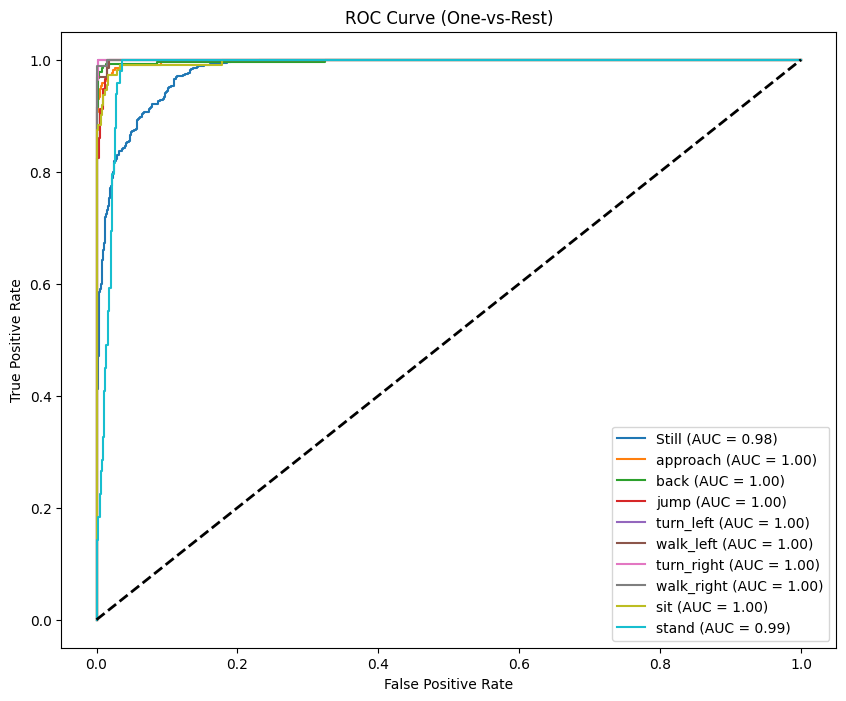

In [105]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=list(label_map.values()))
y_pred_proba = best_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_map.keys()):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()
